In [1]:
import numpy as np
import matplotlib.pyplot as plt
import spectral as sp
import pandas as pd
from scipy.io import loadmat

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import scikitplot as skplt
from sklearn.metrics import classification_report, accuracy_score
import plotly.graph_objects as go
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score
from sklearn.preprocessing import LabelBinarizer

In [2]:
def count_occurrence(arr):
    """
    Count the occurrence of each unique element in the given array.

    Parameters:
    arr (numpy.ndarray): The input array.

    Returns:
    None
    """
    unique_elements, counts = np.unique(arr, return_counts=True)
    for element, count in zip(unique_elements, counts):
        print(f"{element} = {count}")

## Salinas

In [3]:
"""
Load and process Salinas Pines dataset and groundtruth.
"""
def read_HSI():
    X = loadmat('salinas_corrected.mat')['salinas_corrected']
    y = loadmat('salinas_gt.mat')['salinas_gt']
    print(f"X shape: {X.shape}\ny shape: {y.shape}")
    return X, y

in_, out_ = read_HSI()

r_in, c_in, band = in_.shape
r_out, c_out = out_.shape
c = np.unique(out_)

print(f'Dataset Shape: {r_in, c_in, band}\nGroundtruth Shape: {r_out, c_out}\nNumber of Bands: {band}\nClasses: {c}')
count_occurrence(out_)

X shape: (512, 217, 204)
y shape: (512, 217)
Dataset Shape: (512, 217, 204)
Groundtruth Shape: (512, 217)
Number of Bands: 204
Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
0 = 56975
1 = 2009
2 = 3726
3 = 1976
4 = 1394
5 = 2678
6 = 3959
7 = 3579
8 = 11271
9 = 6203
10 = 3278
11 = 1068
12 = 1927
13 = 916
14 = 1070
15 = 7268
16 = 1807


In [4]:
def show_img(img, title):
    """
    Display an image with a colorbar and title.
    Parameters:
    img (numpy.ndarray): The image to be displayed.
    title (str): The title of the image.
    """
    plt.figure(figsize=(6, 4))
    sp.imshow(img, (145, 145, 199), stretch=(0.01, 0.99))
    plt.colorbar(label='Reflectance')
    plt.title(title)
    plt.show()

def plot_band(img, band):
    """
    Plot a band of the image.

    Parameters:
    img (numpy.ndarray): The image to be displayed.
    band (int): The band to be plotted.
    """
    plt.figure(figsize=(6, 4))
    plt.imshow(img[:, :, band], cmap='jet')
    plt.colorbar(label='Reflectance')
    plt.title(f'Band {band}')
    plt.show()

def plot_groundtruth_classes(out_):
    """
    Plot the groundtruth classes.

    Parameters:
    out_ (numpy.ndarray): The array containing the groundtruth classes.
    """
    plt.figure(figsize=(7, 5))
    plt.imshow(out_, cmap='jet')
    plt.colorbar(label='Class')
    plt.title('Groundtruth Classes')
    plt.show()


def overlay_plot(img, gt):
    """
    Plot the image with the groundtruth overlayed.
    Parameters:
    img (numpy.ndarray): The image to be displayed.
    gt (numpy.ndarray): The array containing the groundtruth classes.
    """
    view = sp.imshow(img, (30, 20, 10), classes=gt)
    view.set_display_mode('overlay')
    view.class_alpha = 0.5
    view.set_title('Overlay Plot')


c:\Users\aiqia\anaconda3\Lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


<Figure size 600x400 with 0 Axes>

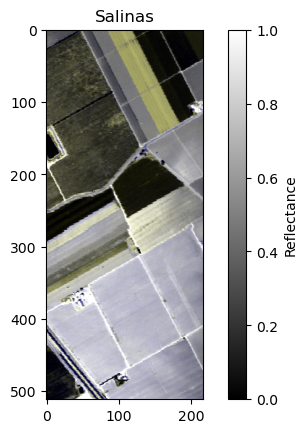

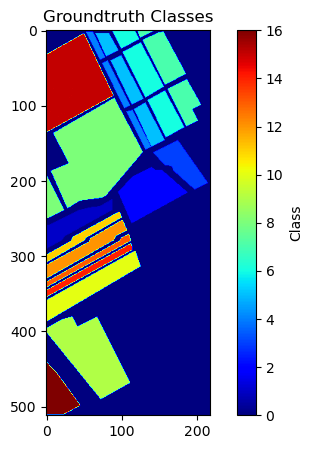

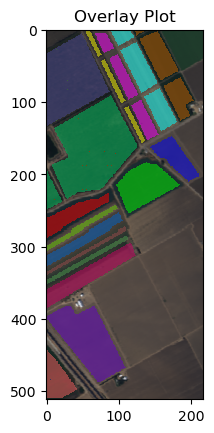

In [5]:
img = in_
gt = out_
show_img(img, 'Salinas')
plot_groundtruth_classes(out_)
overlay_plot(img, gt)

In [6]:
def scale_image(img, scaler=StandardScaler()):
    """
    Reshapes and scales the input image using MinMaxScaler() or StandardScaler()

    Parameters:
    img (ndarray): The input image array.

    Returns:
    ndarray: The scaled image array.
    """

    img_reshaped = img.reshape(-1, img.shape[-1])

    img_scaled = scaler.fit_transform(img_reshaped)
    img_scaled = img_scaled.reshape(img.shape)

    return img_scaled


In [7]:
def pca(img, n_components=3):
    """
    Performs PCA on the input image.

    Parameters:
    img (ndarray): The input image array.
    n_components (int): The number of components to be returned.

    Returns:
    ndarray: The transformed image array.
    """
    pc = sp.principal_components(img)
    sp.imshow(pc.cov, title='Covariance Matrix')

    pc_0999 = pc.reduce(fraction=0.999)
    pcc = len(pc_0999.eigenvalues)

    img_pc = pc_0999.transform(img)
    sp.imshow(img_pc[:, :, :3], stretch_all=True, title='Transformed Image')

    return pcc, img_pc


c:\Users\aiqia\anaconda3\Lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


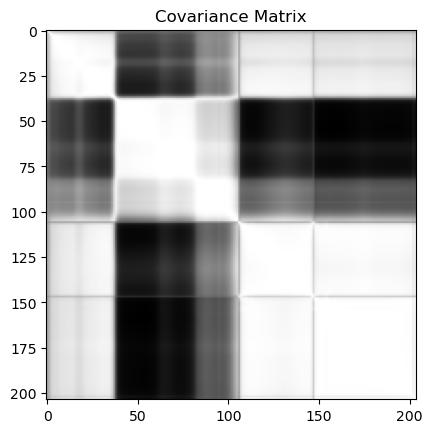

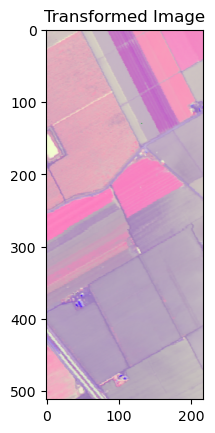

In [8]:
img = scale_image(img, scaler=StandardScaler())
pcc, img_pc = pca(img)

In [9]:
"""
Create a pandas DataFrame from pixel row, pixel column, spectral bands, and class labels.
"""
pix_row = pd.Series([i for i in range(r_in) for _ in range(c_in)])
pix_col = pd.Series([j for _ in range(r_in) for j in range(c_out)])
bands = [pd.Series(img_pc[:, :, i].ravel()) for i in range(img_pc.shape[2])]

df = pd.concat(
    [pd.Series(pix_row.values.reshape(-1)), 
     pd.Series(pix_col.values.reshape(-1)), 
     *bands, 
     pd.Series(out_.reshape(-1))], 
    axis=1)

df.columns = ['pixel_row', 'pixel_col'] + [f'band-{i+1}' for i in range(img_pc.shape[2])] + ['class']

df.head()

,pixel_row,pixel_col,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,...,band-11,band-12,band-13,band-14,band-15,band-16,band-17,band-18,band-19,class
0,0,0,2.104799,12.418382,1.085138,-0.653205,-0.013238,-1.015352,0.290292,-0.106945,...,-0.190905,0.340026,0.116660,0.167459,-0.178800,0.027507,0.085147,0.059831,0.180316,0
1,0,1,1.911410,12.374636,0.782835,-0.716261,-0.067936,-1.244649,0.180619,-0.112063,...,-0.038966,0.117543,0.189687,0.325606,-0.099160,0.028192,-0.035918,0.065604,0.225654,0
2,0,2,2.394143,12.964008,0.909243,-0.740430,-0.269454,-0.929455,0.265335,-0.084584,...,-0.093060,0.154175,0.304052,0.373833,0.133227,-0.038918,0.100506,0.077768,0.157072,0
3,0,3,3.000030,13.834938,1.090857,-0.624876,-0.045306,-0.823793,0.322975,-0.106418,...,-0.189693,-0.016362,0.226832,0.118664,-0.278518,0.068433,0.429514,-0.003545,0.042671,0
4,0,4,3.352986,14.606719,1.041648,-0.838558,-0.096501,-1.438840,0.880978,0.545864,...,-0.213579,-0.116899,0.214106,0.107747,-0.297978,0.040907,0.297407,-0.080992,-0.011882,0


In [10]:
X = df.loc[:, 'band-1':'band-'+str(pcc)].values
y = df['class'].values
count_occurrence(y)
X.shape, y.shape #flattened data

0 = 56975
1 = 2009
2 = 3726
3 = 1976
4 = 1394
5 = 2678
6 = 3959
7 = 3579
8 = 11271
9 = 6203
10 = 3278
11 = 1068
12 = 1927
13 = 916
14 = 1070
15 = 7268
16 = 1807


((111104, 19), (111104,))

In [11]:
def classifier(X_train, y_train, X_test, y_test, classifier, gridsearch=False, silence=False):
    """
    Trains and evaluates a classifier on the given training and test data.

    Parameters:
    - X_train (array-like): Training data features.
    - y_train (array-like): Training data labels.
    - X_test (array-like): Test data features.
    - y_test (array-like): Test data labels.
    - classifier (str): The classifier to use. Supported classifiers are 'svc', 'knn', and 'rfc'.
    - gridsearch (bool): Whether to perform grid search for hyperparameter tuning. Default is False.
    - silence (bool): Whether to suppress printing of accuracy scores. Default is False.

    Returns:
    - y_pred (array-like): Predicted labels for the test data.
    - scr (float): Test accuracy score.
    - clf (object): Trained classifier object.
    """
    if classifier.lower() == 'svc':
        if gridsearch:
            param_grid = {
                'C': [0.1, 1, 10, 100, 1000], 
                'gamma': ['scale'], 
                'kernel': ['rbf']
            }
            clf = GridSearchCV(SVC(random_state=42), param_grid, refit = True, cv = 3, verbose = 3)
        else:
            clf = SVC(C = 100, kernel='rbf', random_state=42, gamma = 'scale')
    elif classifier.lower() == 'knn':
        if gridsearch:
            param_grid = {
                'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19], 
                'weights': ['uniform', 'distance'], 
                'metric': ['euclidean', 'manhattan']
            }
            clf = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, cv = 3, verbose = 3)
        else:
            clf = KNeighborsClassifier(metric='manhattan', n_neighbors = 9, weights='distance')
    elif classifier.lower() == 'rfc':
        if gridsearch:
            param_grid = {
                'n_estimators': [50, 80, 110, 140, 170, 200, 230], 
                #'max_features': ['auto', 'sqrt', 'log2']
            }
            clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, refit = True, cv = 3, verbose = 3)
        else:
            clf = RandomForestClassifier(n_estimators=150, random_state=42)
    else:
        raise ValueError("Invalid classifier. Supported classifiers are 'svc', 'knn' and 'rfc'.")
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scr = clf.score(X_test, y_test)
    
    if not silence and gridsearch:
        print(f"Best Parameters: {clf.best_params_}")
        print(f"Training Accuracy: {clf.best_score_}")
        print(f"Test Accuracy: {scr}")
    elif not silence and not gridsearch:
        print(f"Test Accuracy: {scr}")
    
    return y_pred, scr, clf


In [12]:
X_train, X_test, y_train, y_test, indices_train, indices_test  = train_test_split(X, y,  range(X.shape[0]), test_size = 0.25)

y_pred_svc, scr_svc, clf_svc = classifier(X_train, y_train, X_test, y_test, 'svc', gridsearch=True)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.793 total time= 1.9min
[CV 2/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.796 total time= 2.6min
[CV 3/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.798 total time= 3.0min
[CV 1/3] END ......C=1, gamma=scale, kernel=rbf;, score=0.867 total time= 2.2min
[CV 2/3] END ......C=1, gamma=scale, kernel=rbf;, score=0.866 total time= 2.9min
[CV 3/3] END ......C=1, gamma=scale, kernel=rbf;, score=0.868 total time= 2.5min
[CV 1/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.897 total time= 1.6min
[CV 2/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.898 total time= 1.6min
[CV 3/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.900 total time= 1.7min
[CV 1/3] END ....C=100, gamma=scale, kernel=rbf;, score=0.909 total time= 1.1min
[CV 2/3] END ....C=100, gamma=scale, kernel=rbf;, score=0.910 total time= 1.4min
[CV 3/3] END ....C=100, gamma=scale, kernel=rbf;,

In [13]:
y_pred_knn, scr_knn, clf_knn = classifier(X_train, y_train, X_test, y_test, 'knn', gridsearch=True)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.874 total time=   4.5s
[CV 2/3] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.874 total time=   4.3s
[CV 3/3] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.874 total time=   4.3s
[CV 1/3] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.885 total time=   3.1s
[CV 2/3] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.886 total time=   3.5s
[CV 3/3] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.886 total time=   3.2s
[CV 1/3] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.878 total time=   4.6s
[CV 2/3] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.879 total time=   4.2s
[CV 3/3] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.879 total time=   4.2s
[CV 1/3] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.891 tot

In [14]:
y_pred_rfc, scr_rfc, clf_rfc = classifier(X_train, y_train, X_test, y_test, 'rfc', gridsearch=True)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV 1/3] END ...................n_estimators=50;, score=0.904 total time=  46.1s
[CV 2/3] END ...................n_estimators=50;, score=0.908 total time=  47.3s
[CV 3/3] END ...................n_estimators=50;, score=0.905 total time=  48.9s
[CV 1/3] END ...................n_estimators=80;, score=0.905 total time= 1.3min
[CV 2/3] END ...................n_estimators=80;, score=0.909 total time= 1.3min
[CV 3/3] END ...................n_estimators=80;, score=0.906 total time= 1.3min
[CV 1/3] END ..................n_estimators=110;, score=0.905 total time= 1.7min
[CV 2/3] END ..................n_estimators=110;, score=0.909 total time= 1.6min
[CV 3/3] END ..................n_estimators=110;, score=0.907 total time= 1.6min
[CV 1/3] END ..................n_estimators=140;, score=0.905 total time= 2.1min
[CV 2/3] END ..................n_estimators=140;, score=0.910 total time= 2.1min
[CV 3/3] END ..................n_estimators=140;,

In [ ]:
def clmap(y_pred, title, dim):
    """
    Plot the classification map for the predicted labels.

    Parameters:
    y_pred (array-like): Predicted labels for the test data.
    """    
    clmap = [0]*X.shape[0]
    clmap = [y[idx] if idx in indices_train else clmap[i] for i, idx in enumerate(range(X.shape[0]))]
    clmap = [y_pred[indices_test.index(i)] if i in indices_test else clmap[i] for i in range(X.shape[0])]
    clmap = np.array(clmap).reshape(dim)
    clmap_training = clmap * (gt != 0)
    sp.imshow(classes = clmap_training, title='Training Classification Map - '+title)
    training_errors = clmap_training * (clmap_training != gt)
    sp.imshow(classes = training_errors, title='Training Errors - '+title)

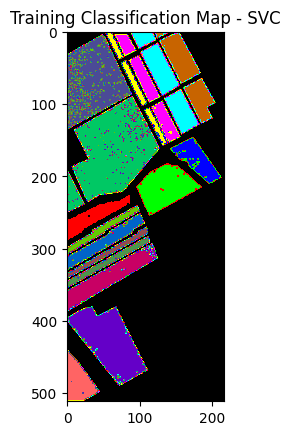

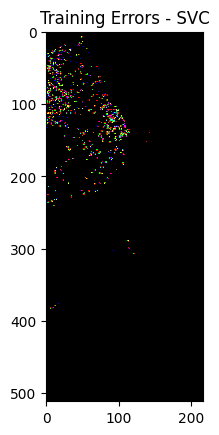

In [ ]:
clmap(y_pred_svc, 'SVC', (r_in, c_in))

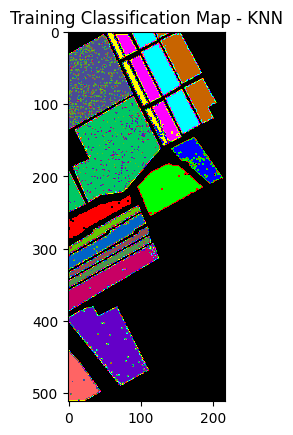

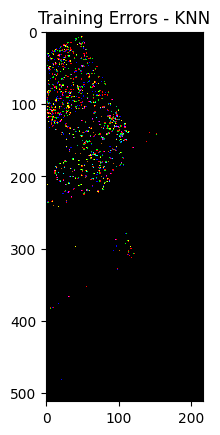

In [ ]:
clmap(y_pred_knn, 'KNN', (r_in, c_in))

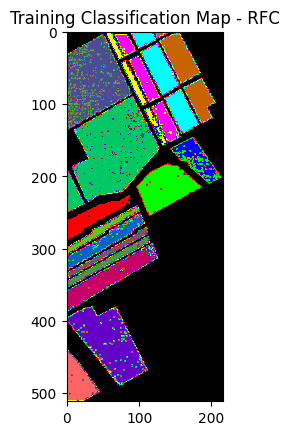

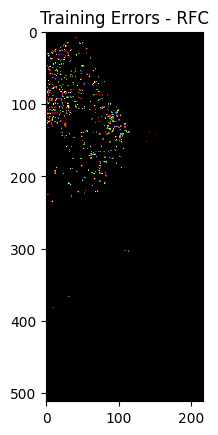

In [ ]:
clmap(y_pred_rfc, 'RFC', (r_in, c_in))

In [ ]:
def plot_classification_report(y_pred, title):
    print('Classification Report - '+ title)
    print('Accuracy: %.2f %%' % (accuracy_score(y_test, y_pred) * 100))
    print(classification_report(y_test, y_pred))

    skplt.metrics.plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix - '+title, figsize=(7,5), cmap='Greens')

In [ ]:
def plot_classification_map(y_pred, title):
    clmap = [0]*X.shape[0]
    clmap = [y[idx] if idx in indices_train else clmap[i] for i, idx in enumerate(range(X.shape[0]))]
    clmap = [y_pred[indices_test.index(i)] if i in indices_test else clmap[i] for i in range(X.shape[0])]

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(np.array(clmap).reshape((r_in, c_in)), cmap='jet')
    plt.colorbar()
    plt.axis('off')
    plt.title('Classification Map - ' + title)

    plt.subplot(1, 2, 2)
    plt.imshow(out_, cmap='jet')
    plt.colorbar()
    plt.axis('off')
    plt.title('True Map')

    plt.tight_layout()
    plt.show()

In [ ]:
def other_metrics(y_pred, title):
    #loss = log_loss(y_test, y_pred, labels=np.unique(y_test))

    lb = LabelBinarizer()
    lb.fit(y_test)

    y_true_bin = lb.transform(y_test)
    y_pred_bin = lb.transform(y_pred)

    roc_auc = roc_auc_score(y_true_bin, y_pred_bin, multi_class='ovr')

    mcc = matthews_corrcoef(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)

    print('Other Metrics - ' + title)
    #print('Log Loss: {}'.format(loss))
    print('AUC-ROC: {}'.format(roc_auc))
    print('Matthews Correlation Coefficient: {}'.format(mcc))
    print("Cohen's Kappa: {}".format(kappa))

Classification Report - SVC
Accuracy: 91.98 %
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     14255
           1       0.86      0.99      0.92       516
           2       0.94      0.98      0.96       955
           3       0.82      0.90      0.85       495
           4       0.93      0.91      0.92       341
           5       0.88      0.96      0.92       681
           6       0.93      0.99      0.96      1009
           7       0.90      0.99      0.95       874
           8       0.81      0.87      0.84      2790
           9       0.95      0.96      0.95      1556
          10       0.94      0.91      0.93       814
          11       0.86      0.90      0.88       245
          12       0.88      0.97      0.92       494
          13       0.86      0.89      0.88       221
          14       0.85      0.92      0.88       251
          15       0.78      0.73      0.75      1828
          16       0.92      0.98  

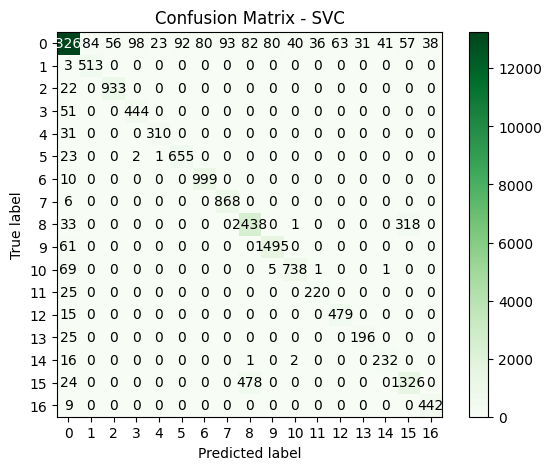

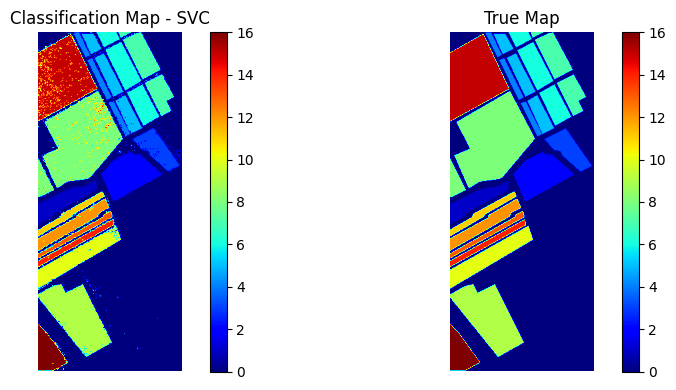

Other Metrics - SVC
AUC-ROC: 0.9611094792966308
Matthews Correlation Coefficient: 0.889380863403624
Cohen's Kappa: 0.8889719232623104


In [ ]:
plot_classification_report(y_pred_svc, 'SVC')
plot_classification_map(y_pred_svc, 'SVC')
other_metrics(y_pred_svc, 'SVC')

Classification Report - KNN
Accuracy: 90.75 %
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     14255
           1       0.88      0.97      0.92       516
           2       0.91      0.99      0.94       955
           3       0.84      0.83      0.83       495
           4       0.89      0.87      0.88       341
           5       0.88      0.95      0.92       681
           6       0.93      0.98      0.95      1009
           7       0.91      0.98      0.95       874
           8       0.79      0.86      0.82      2790
           9       0.92      0.94      0.93      1556
          10       0.87      0.90      0.89       814
          11       0.83      0.84      0.84       245
          12       0.86      0.96      0.91       494
          13       0.85      0.92      0.88       221
          14       0.83      0.89      0.86       251
          15       0.77      0.69      0.73      1828
          16       0.91      0.97  

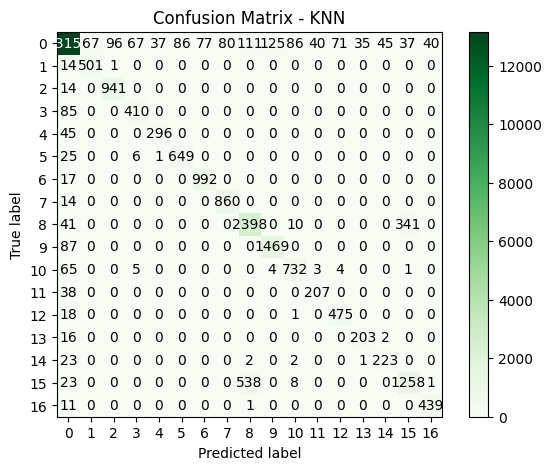

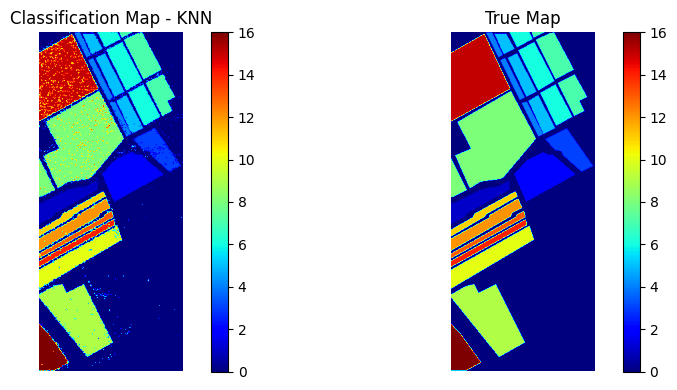

Other Metrics - KNN
AUC-ROC: 0.9516478235750244
Matthews Correlation Coefficient: 0.8723538786076294
Cohen's Kappa: 0.8719317514472708


In [ ]:
plot_classification_report(y_pred_knn, 'KNN')
plot_classification_map(y_pred_knn, 'KNN')
other_metrics(y_pred_knn, 'KNN')

Classification Report - RFC
Accuracy: 91.55 %
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     14255
           1       0.88      0.99      0.93       516
           2       0.93      0.98      0.96       955
           3       0.92      0.68      0.78       495
           4       0.90      0.83      0.87       341
           5       0.91      0.92      0.92       681
           6       0.94      0.97      0.95      1009
           7       0.92      0.98      0.95       874
           8       0.83      0.89      0.86      2790
           9       0.95      0.90      0.92      1556
          10       0.94      0.88      0.91       814
          11       0.89      0.82      0.86       245
          12       0.90      0.88      0.89       494
          13       0.86      0.89      0.87       221
          14       0.83      0.88      0.85       251
          15       0.83      0.74      0.78      1828
          16       0.93      0.96  

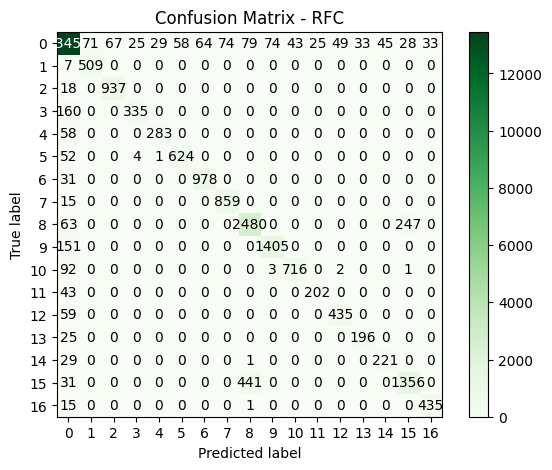

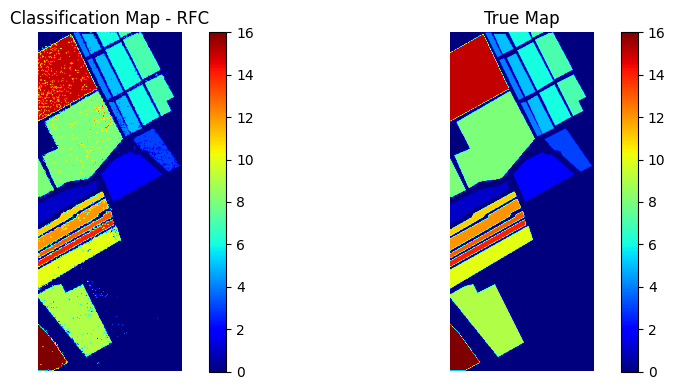

Other Metrics - RFC
AUC-ROC: 0.941668854946268
Matthews Correlation Coefficient: 0.8813094252847731
Cohen's Kappa: 0.8812080350775774


In [ ]:
plot_classification_report(y_pred_rfc, 'RFC')
plot_classification_map(y_pred_rfc, 'RFC')
other_metrics(y_pred_rfc, 'RFC')